In [2]:
# Set timer if one wants to run overnight
import time
time.sleep(420*60)

In [3]:
# Library imports
import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import louvain

from scvi.dataset.dataset import GeneExpressionDataset
from scvi.inference import UnsupervisedTrainer
from scvi.models import SCANVI, VAE

from umap import UMAP

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

[2020-03-05 23:53:27,631] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/thijs/.local/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [4]:
from scvi.dataset.csv import CsvDataset

In [5]:
# Import training data, genes x cells
from scvi.dataset.csv import CsvDataset
mouse1 = CsvDataset(filename="/data/thijs/thesis/shekhar_transposed_downsampled.csv")

[2020-03-05 23:53:35,429] INFO - scvi.dataset.csv | Preprocessing dataset
[2020-03-05 23:53:48,088] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2020-03-05 23:53:48,460] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-03-05 23:53:48,462] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-03-05 23:53:48,656] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-05 23:53:48,804] INFO - scvi.dataset.dataset | Downsampled from 6281 to 6281 cells
[2020-03-05 23:53:48,808] INFO - scvi.dataset.dataset | Not subsampling. No parameter given


In [6]:
# Import test data
mouse2 = CsvDataset(filename="/data/thijs/thesis/macosko_transposed.csv")

[2020-03-05 23:53:48,815] INFO - scvi.dataset.csv | Preprocessing dataset
[2020-03-06 00:08:39,126] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2020-03-06 00:08:43,247] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-03-06 00:08:43,249] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-03-06 00:08:44,710] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-06 00:08:46,871] INFO - scvi.dataset.dataset | Downsampled from 43603 to 43603 cells
[2020-03-06 00:08:46,894] INFO - scvi.dataset.dataset | Not subsampling. No parameter given


In [7]:
# Use GeneExpressionDataset function to harmonize both datasets
all_dataset = GeneExpressionDataset()
all_dataset.populate_from_datasets([mouse1, mouse2])

[2020-03-06 00:08:46,934] INFO - scvi.dataset.dataset | Keeping 12333 genes
[2020-03-06 00:08:47,262] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-06 00:08:48,108] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-03-06 00:08:48,110] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-03-06 00:08:55,762] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-06 00:09:03,793] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-03-06 00:09:03,797] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-03-06 00:09:14,940] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-03-06 00:09:14,942] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]


In [8]:
# Dimensionality check
len(all_dataset.labels)

49884

In [9]:
# Explore full dataset, check if n_cells and nb_genes are correct
all_dataset

GeneExpressionDataset object with n_cells x nb_genes = 49884 x 12333
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'local_means', 'labels', 'batch_indices', 'local_vars'
    cell_categorical_attribute_names: 'labels', 'batch_indices'

In [10]:
# Autoencoder trainer
vae = VAE(all_dataset.nb_genes, n_batch=all_dataset.n_batches, n_labels=all_dataset.n_labels,
          n_hidden=128, n_latent=30, n_layers=2, dispersion='gene')

trainer = UnsupervisedTrainer(vae, all_dataset, train_size=1.0)
n_epochs = 100
trainer.train(n_epochs=n_epochs)

training: 100%|██████████| 100/100 [4:03:50<00:00, 146.30s/it] 


In [11]:
# Check number of batches
vae.n_batch

2

In [12]:
# Obtain posteriors and latent dimensionality
full = trainer.create_posterior(trainer.model, all_dataset, indices=np.arange(len(all_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

In [13]:
# Check latent dimensionality
latent.shape

(49884, 30)

In [14]:
# Save latent dimensionality into dataframe
#latent_df = pd.DataFrame(latent)

In [15]:
# Check
#latent_df.shape

In [16]:
# Save to csv
#latent_df.to_csv("integrated_latent_400epochs.csv")

In [17]:
# Create latent_u for plotting
latent_u = UMAP(spread=2).fit_transform(latent)

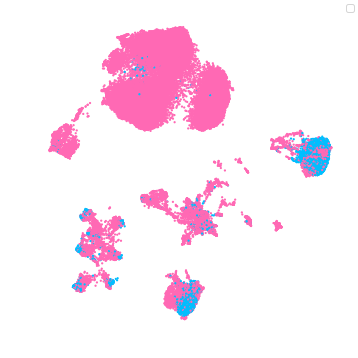

In [18]:
# Plot harmonization
cm = LinearSegmentedColormap.from_list(
        'my_cm', ['deepskyblue', 'hotpink'], N=2)
fig, ax = plt.subplots(figsize=(5, 5))
order = np.arange(latent.shape[0])
random.shuffle(order)
ax.scatter(latent_u[order, 0], latent_u[order, 1], 
           c=all_dataset.batch_indices.ravel()[order], 
           cmap=cm, edgecolors='none', s=5)    
plt.axis("off")
fig.set_tight_layout(True)
fig.legend((all_dataset.batch_indices==0, all_dataset.batch_indices==1), ('Labelled', 'Unlabelled'))
fig.show()

In [19]:
# Import cell labels
from numpy import genfromtxt
mouse1_labels = genfromtxt("/data/thijs/thesis/shekhar_labels_downsampled.csv", skip_header=True, 
                           delimiter="," ,usecols=[2])

In [20]:
# Check labels
mouse1_labels

array([1., 4., 4., ..., 2., 2., 2.])

In [53]:
# Check count for cell types
np.unique(mouse1_labels, return_counts=True)

(array([1., 2., 3., 4., 5.]), array([ 252, 2945,   48, 2945,   91]))

In [21]:
mouse1

GeneExpressionDataset object with n_cells x nb_genes = 6281 x 12333
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'local_means', 'labels', 'batch_indices', 'local_vars'
    cell_categorical_attribute_names: 'labels', 'batch_indices'

In [22]:
mouse1_labels

array([1., 4., 4., ..., 2., 2., 2.])

In [23]:
# Match labels to full dataset
all_dataset.cell_types = np.array(['unlabeled_data','amacrine', 'bipolar', 'cones', 
                                    'muller', 'rods'], dtype = '<U128')

In [24]:
all_dataset.labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint16)

In [25]:
len(all_dataset.labels)

49884

In [26]:
mouse1_labels

array([1., 4., 4., ..., 2., 2., 2.])

In [27]:
len(mouse1_labels)

6281

In [28]:
# reshape labels file to correct shape
mouse1_labels = mouse1_labels.reshape((6281,1))

In [29]:
# Import labels of training data to full dataset
all_dataset.labels[0:6281] = mouse1_labels

In [30]:
# Just a check
all_dataset.labels[1600]

array([4], dtype=uint16)

In [31]:
# Latent representation
full = trainer.create_posterior(trainer.model, all_dataset, indices=np.arange(len(all_dataset)))
full = full.update({"batch_size":32})
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

In [32]:
# Store in dataframe
latent_df = pd.DataFrame(latent)

In [33]:
# Check dimensionality
latent_df.shape

(49884, 30)

In [34]:
# Save to csv
latent_df.to_csv("latent_integrated_mouse_downsampled.csv")

In [35]:
# Preprocessing for plotting
imputed_values = full.sequential().imputation()
normalized_values = full.sequential().get_sample_scale()

In [36]:
import scanpy as sc
import anndata

In [37]:
# plot
post_adata = anndata.AnnData(X=all_dataset.X)
post_adata.obsm["X_scVI"] = latent
post_adata.obs["cell_type"] = np.array([all_dataset.cell_types[all_dataset.labels[i][0]]
                                       for i in range(post_adata.n_obs)])
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.3)

In [38]:
all_dataset.labels.shape

(49884, 1)

... storing 'cell_type' as categorical


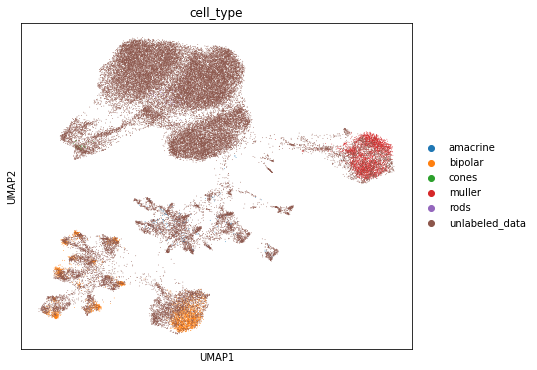

In [39]:
# Plot, labels available for training data, test data remains unlabeled
fig, ax = plt.subplots(figsize = (7,6))
sc.pl.umap(post_adata, color = ["cell_type"], ax=ax, show=True)

In [40]:
# Create reverse scenario of image above
all_dataset_reverse = all_dataset

In [41]:
all_dataset_reverse.labels

array([[1],
       [4],
       [4],
       ...,
       [0],
       [0],
       [0]], dtype=uint16)

In [42]:
from numpy import genfromtxt
mouse2_labels = genfromtxt("/data/thijs/thesis/macosko_labels.csv", 
                                         delimiter="," ,skip_header=True, usecols=(2))

In [43]:
len(mouse2_labels)

43603

In [44]:
mouse2_labels = mouse2_labels.reshape((43603,1))

In [45]:
mouse2_labels.shape

(43603, 1)

In [46]:
all_dataset_reverse.labels[0:6281] = 0

In [47]:
all_dataset_reverse.labels[6281:] = mouse2_labels

In [48]:
all_dataset_reverse.cell_types = np.array(['unlabeled_data','amacrine', 'bipolar', 'cones', 
                                    'muller', 'rods'], dtype = '<U128')

In [49]:
full = trainer.create_posterior(trainer.model, all_dataset_reverse, indices=np.arange(len(all_dataset_reverse)))
full = full.update({"batch_size":32})
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

In [50]:
imputed_values = full.sequential().imputation()
normalized_values = full.sequential().get_sample_scale()

In [51]:
post_adata = anndata.AnnData(X=all_dataset_reverse.X)
post_adata.obsm["X_scVI"] = latent
post_adata.obs["cell_type"] = np.array([all_dataset_reverse.cell_types[all_dataset_reverse.labels[i][0]]
                                       for i in range(post_adata.n_obs)])
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.3)

... storing 'cell_type' as categorical


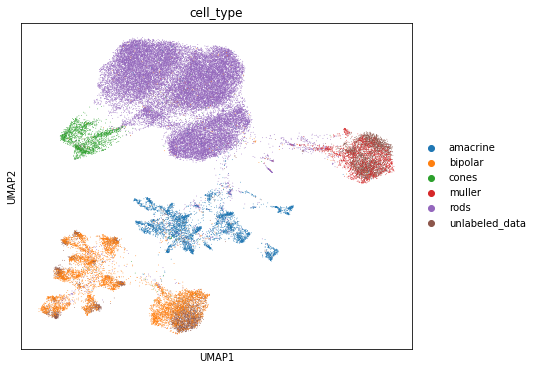

In [52]:
fig, ax = plt.subplots(figsize = (7,6))
sc.pl.umap(post_adata, color = ["cell_type"], ax=ax, show=True)